# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from visualize import *
from data_treatments import *
from feature_selection import *
from models import *

from tp.competitive_learning import *
from tp.linear_model import *
from tp.rbfn import *

# Load data

In [2]:
X1 = pd.read_csv("../data/X1.csv") # [7684 rows x 15 columns]
Y1 = pd.read_csv("../data/Y1.csv",sep='\t',names=["Label"]) # [7684 rows x 1 columns]
X2 = pd.read_csv("../data/X2.csv") # [3787 rows x 15 columns]

# X1 = X1.values # converting pandas dataframe to a numpy array

# Visualize data

In [3]:
#visualize(X1, Y1, 'data.png', True) 

# Data treatments

In [4]:
# step 1 : handle cyclic values

X1_handled = handlecyclic(X1) # handle month, day, hour and wd cyclic features
X1_handled = handle_station(X1_handled) # handle station feature
X1_handled = add_linear_time(X1_handled) # add a global linear time (with year, month, day, hour features)

print(X1_handled.shape)



(7684, 34)


# Visualize new data

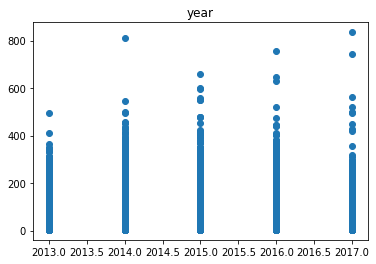

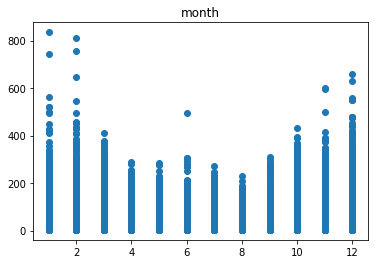

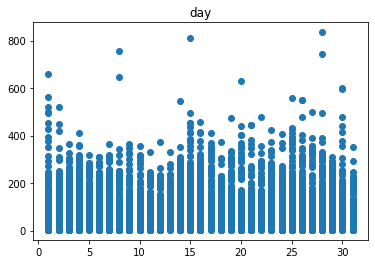

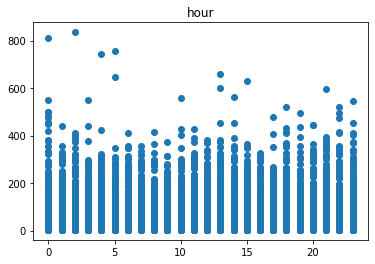

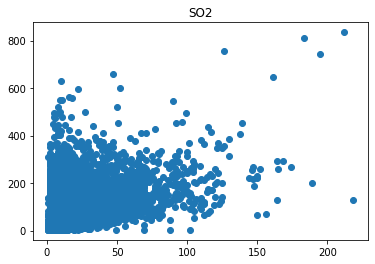

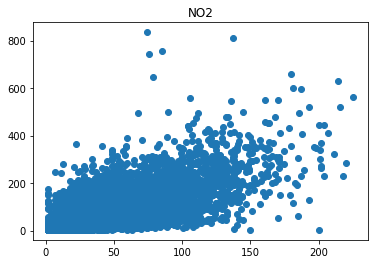

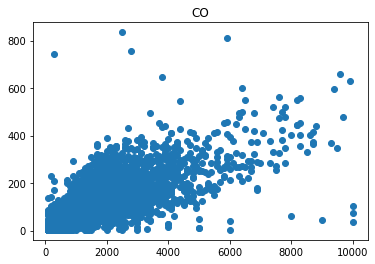

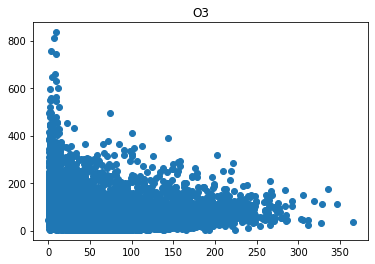

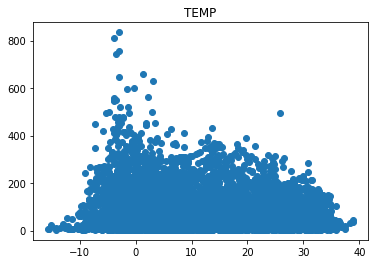

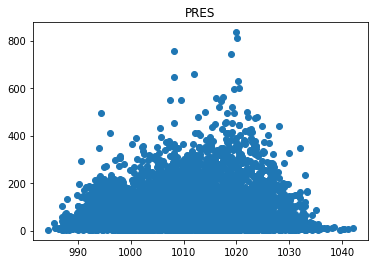

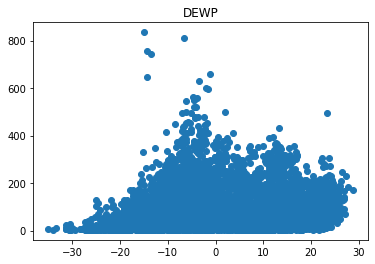

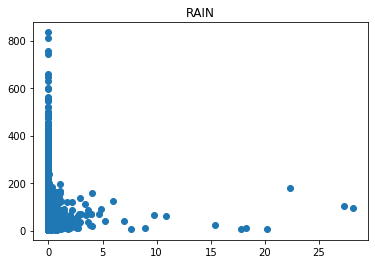

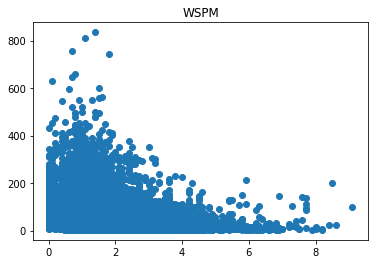

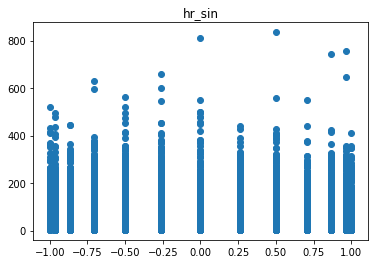

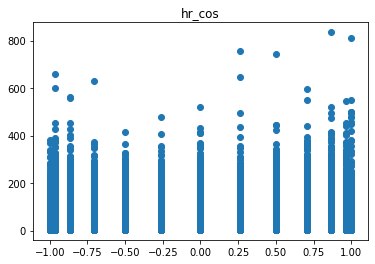

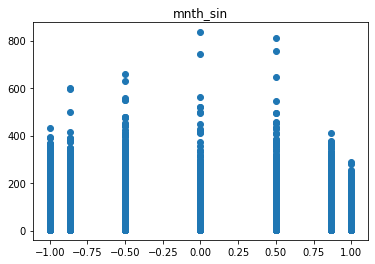

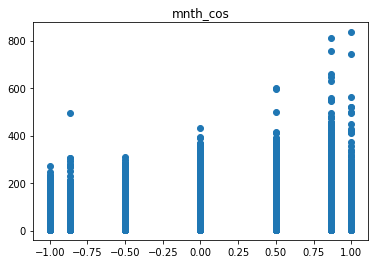

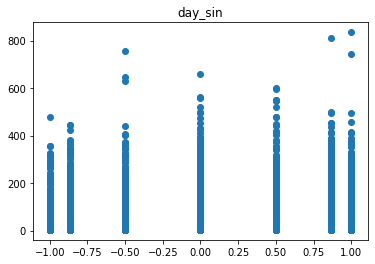

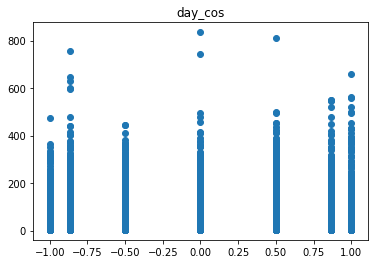

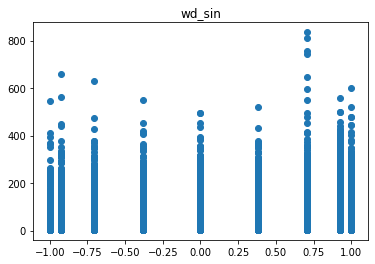

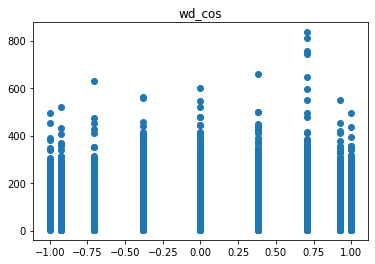

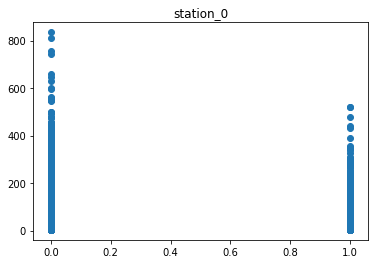

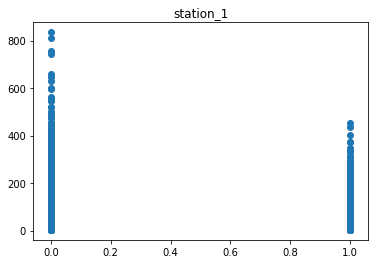

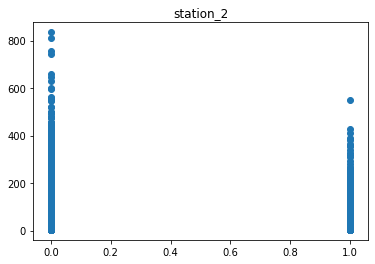

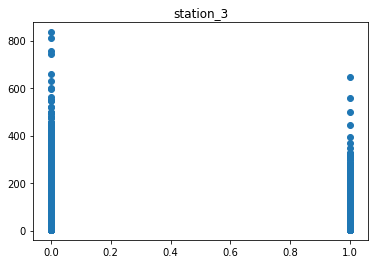

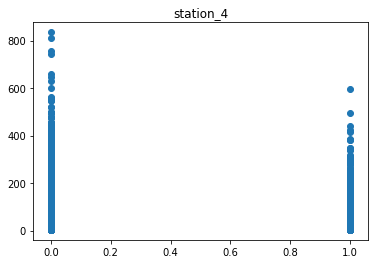

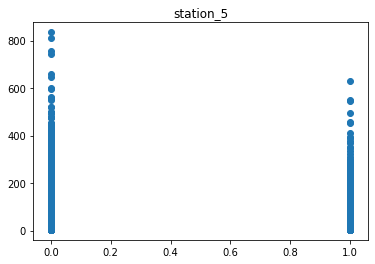

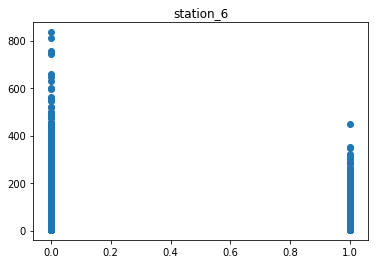

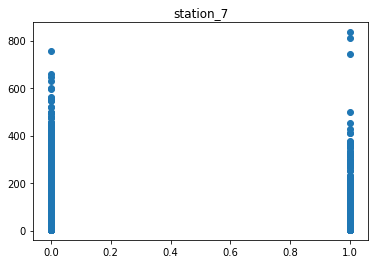

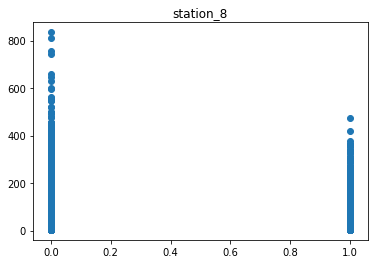

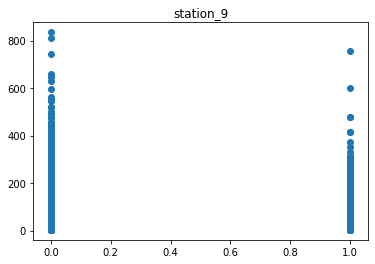

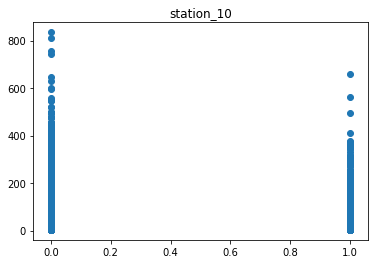

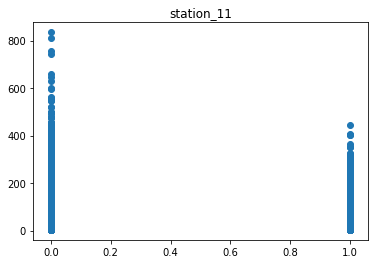

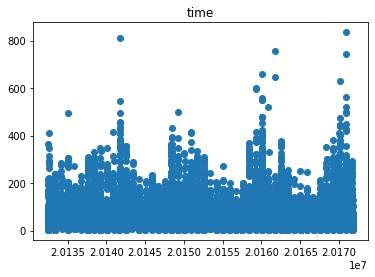

<Figure size 432x288 with 0 Axes>

In [14]:
#visualize(X1_handled, Y1, 'new_data.PNG', True) 

# Data Splitting

In [5]:
# use of random_state parameter ?
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X1_handled, Y1, test_size=0.2, random_state=0)

print(X_train_valid.shape)
print(X_test.shape)
print(Y_train_valid.shape)
print(Y_test.shape)

(6147, 34)
(1537, 34)
(6147, 1)
(1537, 1)


# Normalisation/Standardisation

In [12]:
from scipy.stats import shapiro

'''This funciton takes a imput a dataframe and return a list of the features that are not normal (with threshold alpha)'''


list = isnormal(X_train_valid)


0.0
Sample does not look Gaussian (reject H0) at least for feature: year
6.866362475191604e-44
Sample does not look Gaussian (reject H0) at least for feature: month
1.2096708993283983e-40
Sample does not look Gaussian (reject H0) at least for feature: day
6.693161985001056e-41
Sample does not look Gaussian (reject H0) at least for feature: hour
0.0
Sample does not look Gaussian (reject H0) at least for feature: SO2
0.0
Sample does not look Gaussian (reject H0) at least for feature: NO2
0.0
Sample does not look Gaussian (reject H0) at least for feature: CO
0.0
Sample does not look Gaussian (reject H0) at least for feature: O3
6.0119430452410985e-37
Sample does not look Gaussian (reject H0) at least for feature: TEMP
1.9286870132509833e-24
Sample does not look Gaussian (reject H0) at least for feature: PRES
1.8208140137700628e-38
Sample does not look Gaussian (reject H0) at least for feature: DEWP
0.0
Sample does not look Gaussian (reject H0) at least for feature: RAIN
0.0
Sample does no

In [6]:
# normalization
X_norm = norm(X_train_valid)
X_norm = pd.DataFrame(X_norm)
X_norm.columns = X_train_valid.columns

X_norm_test = norm(X_test)
X_norm_test = pd.DataFrame(X_norm_test)
X_norm_test.columns = X_test.columns

# standardisation
X_stand = stand(X_train_valid)
X_stand = pd.DataFrame(X_stand)
X_stand.columns = X_train_valid.columns

X_stand_test = stand(X_test)
X_stand_test = pd.DataFrame(X_stand_test)
X_stand_test.columns = X_test.columns


# Feature selection

In [83]:
# feature selection

# previously
'''
n = 7 # number of feature to select
most_mi = print_mutual_information(X1_handled, X_stand.values, Y_train_valid.values.ravel(), 10)
a = len(most_mi)
index_selected = most_mi[a-n:a]
print(index_selected)
X1 = X_stand.values[:,index_selected]
X1_test = X_stand_test.values[:,index_selected]
'''

features = features_selection(X_stand, Y_train_valid.values.ravel(), 7)
#features = features_selection(X_norm, Y_train_valid.values.ravel(), 7)

X_selected = X_stand[features]
#X_selected = X_norm[features]

X_test_selected = X_stand_test[features]
#X_test_selected = X_norm_test[features]

print(X_selected.columns)
print(X_test_selected.columns)

Index(['WSPM', 'O3', 'SO2', 'hr_sin', 'CO', 'NO2', 'DEWP', 'wd_sin', 'TEMP',
       'PRES', 'mnth_cos', 'time'],
      dtype='object')
Index(['WSPM', 'O3', 'SO2', 'hr_sin', 'CO', 'NO2', 'DEWP', 'wd_sin', 'TEMP',
       'PRES', 'mnth_cos', 'time'],
      dtype='object')


# Building model

In [23]:
def build_model(X_train, Y_train, X_test, Y_test, model):
    rmse = 1000
    
    if model[0]=='linear_regression_tp':
        rmse = linear_regression_tp(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='rbfn_tp':
        rmse = rbfn_tp(X_train, Y_train, X_test, Y_test, model[1], model[2])
    
    elif model[0] =='KNN':
        rmse = KNN(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='linear_regression':
        rmse = linear_regression(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='tree':
        rmse = tree(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='random_forest':
        rmse = random_forest(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='MLperceptron':
        rmse = MLperceptron(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='SVM':
        rmse = SVM(X_train, Y_train, X_test, Y_test)
    
    else:
        print('incorrect value for model')
    return rmse
    
    

In [10]:
rmse = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['rbfn_tp', [20, 30, 40], [4,8]])
rmse # 41.109355030141586 # with stand, X_test_selected

n_center =  20
smooth_f =  4
smooth_f =  8
n_center =  30
smooth_f =  4
smooth_f =  8
n_center =  40
smooth_f =  4
smooth_f =  8


40.728885700161854

In [11]:
rmse = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['linear_regression_tp'])
rmse # 45.81350958024227 # with stand, X_test_selected
# 46.555418705773626 # with norm, X_test_selected

47.5009732912099

In [12]:
rmse_knn = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['KNN'])
rmse_knn # 41.25390056831065 # with stand, X_test_selected
# 45.50425826121668 # with norm, X_test_selected

42.7422616742308

In [13]:
rmse_lin_reg = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['linear_regression'])
rmse_lin_reg # 45.813509580242275 # with stand, X_test_selected
# 46.55541870577369 # with norm, X_test_selected

47.5009732912099

In [ ]:
rmse_tree = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['tree'])
rmse_tree
# very time expensive
# 106.71974709600715 # with stand, X_test_selected
# 108.58110978903885 # with norm, X_test_selected

In [ ]:
rmse_rf = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['random_forest'])
rmse_rf # 102.87238489221627 # with stand, X_test_selected
# 105.65649031239074 # with norm, X_test_selected

In [ ]:
rmse_mlp = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['MLperceptron'])
rmse_mlp # 107.77550719298902 # with stand, X_test_selected
# 108.22558752681337 # # with norm, X_test_selected

In [15]:
rmse_svm = build_model(X_selected, Y_train_valid, X_test_selected, Y_test, ['SVM'])
rmse_svm # 101.41083882437974, # with stand, X_test_selected
# 103.97616339884539 # with norm, X_test_selected

NameError: name 'build_model' is not defined

# Outilers

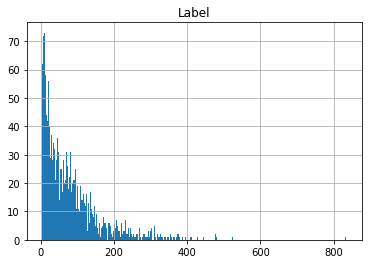

In [9]:
#The histrogam below plot the output Y1 for the train-valid set
hist = Y_test.hist(bins=300)



In [62]:

i = 400
X_selected_outliers = X_selected.loc[list(Y_train_valid['Label']<i)]
Y_train_valid_outliers = Y_train_valid[list(Y_train_valid['Label']<i)]
print(X_selected.shape)
print(X_selected_outliers.shape)



(6147, 12)
(6104, 12)


In [63]:
rmse_lin_reg_outlier = build_model(X_selected_outliers, Y_train_valid_outliers, X_test_selected, Y_test, ['linear_regression'])
rmse_lin_reg_outlier # 45.813509580242254 # with stand, X_test_selected
                    # 46.32600875114827 # with stand, X_test_selected_outlier

46.32600875114827

In [64]:
rmse_knn_outlier = build_model(X_selected_outliers, Y_train_valid_outliers, X_test_selected, Y_test, ['KNN'])
rmse_knn_outlier # 41.25390056831065 # with stand, X_test_selected
                # 44.26778845376413  # with stand, X_test_selected_outlier

44.26778845376413

# Reducing dimentions: PCA

In [100]:
from sklearn.decomposition import PCA

pca = PCA()

pca = PCA(n_components=5)
pca.fit_transform(X_selected)

print(pca.explained_variance_ratio_)
print("pca.explained_variance_ratio_ = ", np.sum(pca.explained_variance_ratio_))


[0.35502751 0.19538106 0.11801458 0.08570068 0.07039006]
pca.explained_variance_ratio_ =  0.8245138830181628


In [101]:
X_selected_pca = pd.DataFrame(pca.transform(X_selected))
X_test_selected_pca = pd.DataFrame(pca.transform(X_test_selected))
print(X_selected_pca)


             0         1         2         3         4
0     1.189568 -2.245172  1.642893 -2.142358  0.485531
1     0.947552  1.830980  3.369820 -1.429561 -0.795126
2    -2.566295 -0.101178 -0.697855  1.304810 -0.593805
3    -1.555618 -0.394451 -1.115205 -1.978427  1.246530
4     1.446396  1.781427 -0.519382  0.610410 -1.271203
...        ...       ...       ...       ...       ...
6142  1.167303 -2.110964  1.432989  1.560945  2.277701
6143  1.082549  3.788529  0.668611 -0.697036  0.199928
6144  2.569195  0.586307  2.311932 -0.892570  0.623153
6145 -3.074493  0.627030  1.684036  0.144791  0.706035
6146 -1.680850 -0.438973 -0.816535 -0.818228  0.894204

[6147 rows x 5 columns]


In [102]:
rmse_lin_reg_pca = build_model(X_selected_pca, Y_train_valid, X_test_selected_pca, Y_test, ['linear_regression'])
rmse_lin_reg_pca # 45.813509580242254 # with stand, X_test_selected
                    # 52.12101428226876 # with stand, X_test_selected_pca

52.12101428226876